In [40]:
import qiskit
import qiskit_algorithms
import qiskit_optimization

from qiskit_aer import AerSimulator

from qiskit.primitives import Sampler
# from qiskit.primitives import BackendSamplerV2 
# from qiskit.primitives import StatevectorSampler #takes 2 args but 3 are passed assuming Sampler :(
# from qiskit_ibm_runtime import SamplerV2 #needs backend

from qiskit.circuit.library import QAOAAnsatz

from qiskit_algorithms import QAOA, SamplingVQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import COBYLA

from qiskit_optimization.algorithms import MinimumEigenOptimizer, SolutionSample, OptimizationResultStatus
from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.converters import LinearEqualityToPenalty, LinearInequalityToPenalty, QuadraticProgramToQubo
from qiskit_optimization.translators import from_docplex_mp # creates QuadraticProgram from docplex model

from qiskit.visualization import plot_histogram, plot_state_city, plot_state_qsphere, plot_bloch_multivector, plot_distribution

import networkx as nx
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

import math
import time
import contextlib
import io
from IPython.display import display, Math

# from qiskit_algorithms.utils import algorithm_globals
# algorithm_globals.random_seed = 123

import warnings
# Suppress specific DeprecationWarning
warnings.filterwarnings('ignore', category=DeprecationWarning)


print("qiskit version:",qiskit.__version__)
print("qiskit algorithms version:",qiskit_algorithms.__version__)
print("qiskit optimization version:",qiskit_optimization.__version__)

qiskit version: 1.3.2
qiskit algorithms version: 0.3.1
qiskit optimization version: 0.6.1


In [41]:
# Load MATLAB file
data = scipy.io.loadmat('ifiss3.6/QUBO.mat')

# Extract matrices as NumPy arrays
Phi = np.array(data['Phi'])
M = np.array(data['M'].toarray())
Kinv = np.array(data['Kinv'])
yhat_vec = np.array(data['yhat_vec']).squeeze()  # for 1D array

print('Phi shape:', Phi.shape)
print('M shape:', M.shape)
print('Kinv shape:', Kinv.shape)
print('yhat_vec shape:', yhat_vec.shape)

Phi shape: (25, 16)
M shape: (25, 25)
Kinv shape: (25, 25)
yhat_vec shape: (25,)


In [42]:
def generate_pde_qubo(M, Kinv, Phi, yd):
    
    Q = np.array((1/2) * Phi.T @ M @ Kinv @ M @ Kinv @ M @ Phi)

    q = np.array((1/2) * (yd.T @ M @ Kinv @ M @ Phi).T - (Phi.T @ M @ Kinv.T @ M @ yd))

    c = np.array((1/2) * yd.T @ M @ yd.T)

    return Q, q, c

Q, q, c = generate_pde_qubo(M, Kinv, Phi, yhat_vec)

print('Q shape: ', Q.shape)
print('q shape: ', q.shape)
print('c shape: ', c.shape)

Q shape:  (16, 16)
q shape:  (16,)
c shape:  ()


In [43]:
#set random seed
#np.random.seed(1234)

display(Math(r"\min_{x\in\{0,1\}^n} x^T Q x + q^T x + c \quad \text{s.t.} \quad x^T x = k"))

# make an empty problem
prob_size = q.size
k=3

bqo = QuadraticProgram("PDE constrained QBO")
binary_vars = [bqo.binary_var(name=f"x{i}") for i in range(prob_size)]

# Add the Hamming weight constraint: sum(x[i]) == k
bqo.linear_constraint(
    linear={f"x{i}": 1 for i in range(prob_size)},
    sense="==",
    rhs=k,
    name="hamming_weight"
)

# Add objective function using lists/arrays
bqo.minimize(
    constant=c,
    linear=q,
    quadratic=Q
    )

print(bqo.prettyprint())

<IPython.core.display.Math object>

Problem name: PDE constrained QBO

Minimize
  1.0491111988920472*x0^2 + 2.011519516413439*x0*x1 + 2.2843835670086405*x0*x10
  + 2.091979353133606*x0*x11 + 2.203148887495436*x0*x12
  + 2.367246131968998*x0*x13 + 2.1235441585795574*x0*x14
  + 1.9742666161262132*x0*x15 + 2.054780537137039*x0*x2 + 2.04243124698583*x0*x3
  + 1.8536686298751572*x0*x4 + 1.960689101981972*x0*x5
  + 2.0376896210586555*x0*x6 + 1.6898628036144352*x0*x7
  + 2.2923981887555955*x0*x8 + 2.3584511455270527*x0*x9
  + 1.2898509748427225*x1^2 + 2.3657896525995836*x1*x10
  + 1.8477875094809058*x1*x11 + 2.616486858265148*x1*x12
  + 2.217062824191619*x1*x13 + 2.137481956274674*x1*x14
  + 2.317789198090355*x1*x15 + 2.2360064367871515*x1*x2
  + 2.6380580296359915*x1*x3 + 1.8682799144673892*x1*x4
  + 2.0015275909179895*x1*x5 + 1.8470111426100666*x1*x6
  + 1.7635263648610118*x1*x7 + 2.3083565990686887*x1*x8
  + 2.152413478071307*x1*x9 + 1.30157945368918*x10^2
  + 2.2233605070090334*x10*x11 + 2.606677591292845*x10*x12
  + 2.7008

In [44]:
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms import NumPyMinimumEigensolver

# Assuming bqo is an instance of QuadraticProgram
# Create a classical solver
eigen_solver = NumPyMinimumEigensolver()

# Create the optimizer
optimizer = MinimumEigenOptimizer(eigen_solver)

# Solve the problem
result = optimizer.solve(bqo)
optimal_value = result.fval

# Print the solution
print("solution:", result.prettyprint())

solution: objective function value: 6.003947797375644
variable values: x0=0.0, x1=0.0, x2=0.0, x3=0.0, x4=1.0, x5=1.0, x6=0.0, x7=1.0, x8=0.0, x9=0.0, x10=0.0, x11=0.0, x12=0.0, x13=0.0, x14=0.0, x15=0.0
status: SUCCESS


In [45]:
bqo.remove_linear_constraint("hamming_weight") # to enforce with mixer instead of penalty

In [46]:
# make initial state
from qiskit import QuantumCircuit

init_qc = QuantumCircuit(prob_size)
for idx in range(k):
    init_qc.x(idx)

#init_qc.draw(output="mpl")

In [47]:
from qiskit.circuit import Parameter, QuantumCircuit

beta = Parameter("β")

full_xy_mixer = QuantumCircuit(prob_size, name="Full XY Mixer")
# For each qubit pair, apply RXX and RYY gates
for idx in range(prob_size):
    for idy in range(idx):
        # The factor of 2*beta is used here to match the generator normalization;
        # adjust if needed for your application.
        full_xy_mixer.rxx(2 * beta, idx, idy)
        full_xy_mixer.ryy(2 * beta, idx, idy)
        full_xy_mixer.barrier()


ring_xy_mixer = QuantumCircuit(prob_size, name="Ring XY Mixer")
# For each adjacent qubit pair, apply RXX and RYY gates
for idx in range(prob_size):
    if idx == prob_size-1:
        idy = 0
    else:
        idy = idx + 1
    ring_xy_mixer.rxx(2 * beta, idx, idy)
    ring_xy_mixer.ryy(2 * beta, idx, idy)
    ring_xy_mixer.barrier()

# ring_xy_mixer.draw(output='mpl')

In [48]:
# parameters
backend = AerSimulator()
sampler = Sampler()
cvar_alpha = 1 # alpha for CVaR aggregation in (0,1], 1 for full distribution, 0 for only the best solution
shots = 1024/cvar_alpha
sampler.set_options(shots=shots, backend=backend)
optimizer = COBYLA()
reps = 3
initial_point = np.zeros(2 * reps)

# solvers
qaoa = QAOA(
    sampler=sampler, 
    optimizer=optimizer, 
    reps=reps,
    initial_state=init_qc,
    mixer=ring_xy_mixer,
    initial_point=initial_point,
    aggregation=cvar_alpha
    )

np_solver = NumPyMinimumEigensolver() # exact classical solver
# create minimum eigen optimizer based on solver used
qaoa_optimizer = MinimumEigenOptimizer(qaoa)

In [49]:
qaoa_result = qaoa_optimizer.solve(bqo)
samples = qaoa_result.samples
for sample in samples:
    sample.fval = bqo.objective.evaluate(sample.x)
samples.sort(key=lambda x: x.fval, reverse=False) #fvals are in ascending order so best first (for minimization)

samples

[SolutionSample(x=array([0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]), fval=6.218309718796492, probability=0.00390625, status=<OptimizationResultStatus.SUCCESS: 0>),
 SolutionSample(x=array([0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.]), fval=6.234172230387315, probability=0.00390625, status=<OptimizationResultStatus.SUCCESS: 0>),
 SolutionSample(x=array([0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]), fval=6.406121212925509, probability=0.0009765625, status=<OptimizationResultStatus.SUCCESS: 0>),
 SolutionSample(x=array([0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.]), fval=6.42602166382441, probability=0.0009765625, status=<OptimizationResultStatus.SUCCESS: 0>),
 SolutionSample(x=array([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]), fval=6.53113863058404, probability=0.0234375, status=<OptimizationResultStatus.SUCCESS: 0>),
 SolutionSample(x=array([1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 

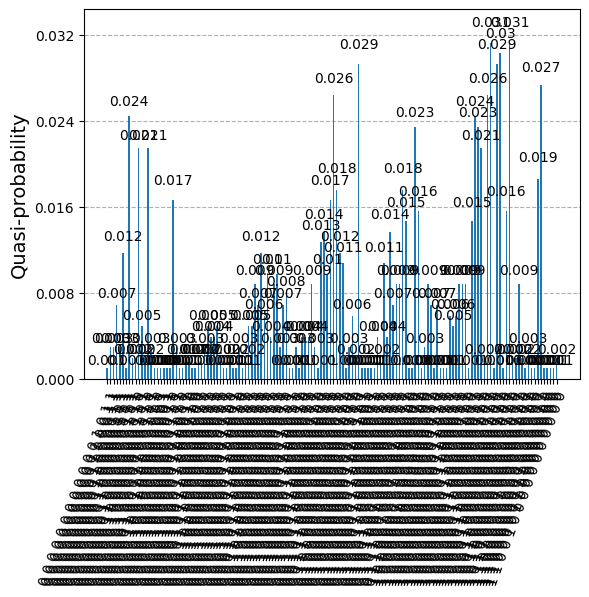

In [50]:
samples_for_plot = {
    " ".join(f"{int(v)}" for i, v in enumerate(s.x)): s.probability
    for s in samples
}

plot_histogram(samples_for_plot)

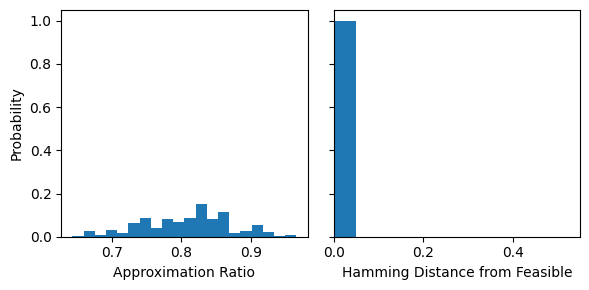

In [51]:
probabilities = [sample.probability for sample in samples]
approx_ratios = [optimal_value / sample.fval for sample in samples]
hamming_distances = [abs(sum(sample.x) - k) for sample in samples]

fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharey=True)

# Plot Approximation Ratio
axs[0].hist(approx_ratios, bins=20, weights=probabilities)
axs[0].set_xlabel("Approximation Ratio")
axs[0].set_ylabel("Probability")

# Plot Hamming Distance
axs[1].hist(hamming_distances, bins=20, weights=probabilities)
axs[1].set_xlabel("Hamming Distance from Feasible")
axs[1].set_xlim(left=0)

plt.tight_layout()
plt.show()

In [52]:
# We are minimizing fval
best_sample = samples[0]
best_sample_formatted = [int(x_i) for x_i in best_sample.x]
prob_best_sample = best_sample.probability
best_fval = best_sample.fval

samples.sort(key=lambda x: x.probability, reverse=True)
most_probable_sample = samples[0]
most_probable_sample_formatted = [int(x_i) for x_i in most_probable_sample.x]
prob_most_probable_sample = most_probable_sample.probability
most_probable_fval = most_probable_sample.fval

print(f"Best sample: {best_sample_formatted} with probability {prob_best_sample}")
print(f"Best value: {best_fval}")
print(f"Best approx ratio: {optimal_value / best_fval}")
print()
print(f"Most probable sample: {most_probable_sample_formatted} with probability {prob_most_probable_sample}")
print(f"Most probable value: {most_probable_fval}")
print(f"Most probable approx ratio: {optimal_value / most_probable_fval}")
print()
print(f"classical solution: {bqo.objective.evaluate(result.x)}")

Best sample: [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1] with probability 0.00390625
Best value: 6.218309718796492
Best approx ratio: 0.965527300646849

Most probable sample: [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0] with probability 0.03125
Most probable value: 6.9552062947219095
Most probable approx ratio: 0.8632307286028099

classical solution: 6.003947797375644
